In [1]:
%run DensityPeakEstimation.ipynb

In [2]:
mat_data = scipy.io.loadmat('SalinasA.mat')
data = mat_data["salinasA"]
x, y, z = data.shape
salinasA = data.reshape((x*y, z))
norms = np.linalg.norm(salinasA, axis=1)
# Normalize each pixel vector by dividing by its norm
salinasA = salinasA / norms[:, np.newaxis]
mat_data_gt = scipy.io.loadmat('SalinasA_gt.mat')
gt = mat_data_gt["salinasA_gt"]
gt = gt.reshape(-1)

In [3]:
def land(X, K, GT, B, t):
    
    n = X.shape[0]
    Labels = np.zeros(n)
    
    Adj = make_adjacency(X, K)
    kernel = gaussian_kernel(Adj)
    diffusion = diffusion_map(kernel)
    
    
    Embed = embed(diffusion, t)
    embedding = Embed[0]
    PWDiffDist = diffusion_dist(embedding)
    PWdist = cdist(X, X)
    Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist)
    centers = density_peaks_estimation(Delta_Density, B)
    
    total_c = []
    
    t = B
    it = 0
    while t > 0:
        
        while GT[centers[it]] == 0:
            it += 1
        
            #print(centers[it])
        Labels[centers[it]] = GT[centers[it]] + 1 
        #print(centers[it])
        total_c.append(centers[it])
        t-=1
        it += 1
    print(np.where(Labels != 0))
    
    
    # Sort points by density
    siD = sorted(enumerate(Density_), key=lambda x: x[1], reverse=True)
    
    idx = np.array([int(index) for index, _ in siD])

    
    # Label highest density point if necessary
    
    if Labels[idx[0]] == 0:
        Labels[idx[0]] = GT[idx[0]] + 1
    
    
    # First pass
    row_max = np.max(diffusion, axis=1)

    for j in range(n):
        if Labels[idx[j]] == 0:
            NN = np.argmin(PWDiffDist[idx[j], idx[:j]])
            Labels[idx[j]] = Labels[idx[NN]]
    print(set(total_c))
    print(len(set(total_c)))
    return Labels

In [36]:
def lend(X, K, GT, B, t, J, alpha):
    
    n = X.shape[0]
    Labels = np.zeros(n)
    Adj = make_adjacency(X, K)
    kernel = gaussian_kernel(Adj)
    diffusion = diffusion_map(kernel)
    Embed = embed(diffusion, t)
    embedding = Embed[0]
    PWdist = cdist(X, X)
    PWDiffDist = diffusion_dist(embedding)
    Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist)
    
    total_c = []
    for iter in range(J):
        
        Labels = np.zeros(n)
       
        Embed = embed(diffusion, t)
        embedding = Embed[0]
        PWDiffDist = diffusion_dist(embedding)
        
        Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist, Density_)
        centers = density_peaks_estimation(Delta_Density, B - (2 - iter))
        
        t = B - ( (J-1) - iter)
        it = 0
        while t > 0:
            while GT[centers[it]] == 0:
                it += 1
            Labels[centers[it]] = GT[centers[it]] + 1 #+1 to ensure unlabeled points have value of 0
            #print(centers[it])
            total_c.append(centers[it])
            t-=1
            it += 1
        
        # Sort points by density
        siD = sorted(enumerate(Density_), key=lambda x: x[1], reverse=True)
        # Extracting just the indices and converting to NumPy array
        idx = np.array([int(index) for index, _ in siD])
        # Label highest density point if necessary
        if Labels[idx[0]] == 0:
            Labels[idx[0]] = GT[idx[0]] + 1
        # First pass
        row_max = np.max(diffusion, axis=1)
        for j in range(n):
            if Labels[idx[j]] == 0:
                NN = np.argmin(PWDiffDist[idx[j], idx[:j]])
                Labels[idx[j]] = Labels[idx[NN]]
        mask = Labels[:, None] == Labels  # Create a mask where labels are equal
        mask[mask == 0] = alpha
        diffusion *= mask
        #diffusion_u = diffusion* mask  # Element-wise multiplication to set non-equal label positions to 0
        #diffusion = (diffusion_u + diffusion) /2
        row_sums = diffusion.sum(axis=1)
        diffusion = diffusion / row_sums[:, np.newaxis]
        
    print(len(set(total_c)))
    print(set(total_c))
    return Labels
    

In [5]:
'''
Example usage:
Fill in with desired params, adjust for +1 in labeling, then calculate accuracy over nonzero labels.
'''
LAND = land(salinasA, 100, gt, 10, 30)

K 500
(array([  26,  310,  396,  482, 1600, 1686, 2224, 2310, 3802, 6081]),)
{1600, 6081, 482, 26, 2310, 396, 2224, 310, 1686, 3802}
10


In [6]:
LAND -=1

In [8]:

mask = gt != 0
    # Calculate the difference only where the mask is True
difference = LAND[mask] != gt[mask]
    # Calculate the desired value
result = 1 - np.sum(difference) / np.sum(mask)

In [9]:
result

0.7290575916230366

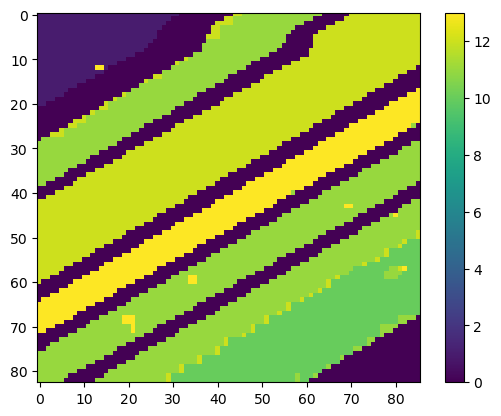

In [13]:
plt.imshow(LAND.reshape(83, 86) * mask.reshape(83, 86))
plt.colorbar()

In [37]:
'''
Example usage of LEND, returns all query points
'''
LEND = lend(salinasA, 100, gt, 18, 30, 3, .75)

K 500
K 500
K 500
K 500
18
{1600, 6081, 482, 26, 5153, 2310, 6310, 4552, 3595, 396, 2224, 6097, 3509, 310, 1686, 3802, 6396, 4447}


In [38]:
LEND -= 1

In [39]:
mask = gt != 0
    # Calculate the difference only where the mask is True
difference = LEND[mask] != gt[mask]
    # Calculate the desired value
result = 1 - np.sum(difference) / np.sum(mask)

In [40]:
result

0.9796185489902768

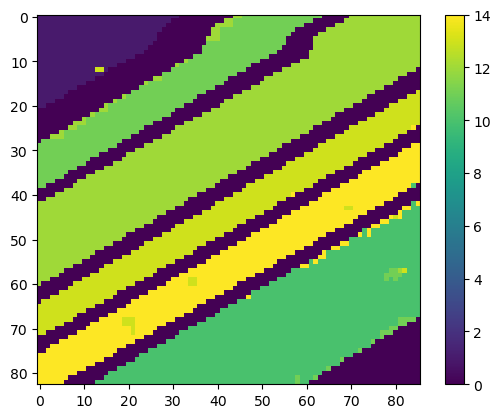

In [42]:
plt.imshow(LEND.reshape(83, 86)*mask.reshape(83, 86))
plt.colorbar()